# LangGraphで作るAIエージェント実践入門

## 9.3 ハンズオン：Q&Aアプリケーション

In [ ]:
# uvを使っている場合はインストール済みです。
# !pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22

In [ ]:
# google colab 用なのでコメントアウト
# import os
# from google.colab import userdata

# os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_PROJECT"] = "agent-book"

In [1]:
from dotenv import load_dotenv

# 事前に .env ファイルを作って、OPENAI_API_KEY, LANGCHAIN_ENDPOINT, TAVILY_API_KEY などを設定してください
load_dotenv()

True

In [2]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。",
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。",
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。",
    },
}

In [3]:
import operator
from typing import Annotated

from pydantic import BaseModel, Field


class State(BaseModel):
    query: str = Field(..., description="ユーザーからの質問")
    current_role: str = Field(default="", description="選定された回答ロール")
    messages: Annotated[list[str], operator.add] = Field(default=[], description="回答履歴")
    current_judge: bool = Field(default=False, description="品質チェックの結果")
    judgement_reason: str = Field(default="", description="品質チェックの判定理由")

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)  # もともとは gpt-4o です。
# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id="max_tokens"))

In [5]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()])
    prompt = ChatPromptTemplate.from_template(
        """質問を分析し、最も適切な回答担当ロールを選択してください。

選択肢:
{role_options}

回答は選択肢の番号（1、2、または3）のみを返してください。

質問: {query}
""".strip()
    )
    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]["name"]
    return {"current_role": selected_role}

In [6]:
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
        """あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

役割の詳細:
{role_details}

質問: {query}

回答:""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return {"messages": [answer]}

In [7]:
class Judgement(BaseModel):
    judge: bool = Field(default=False, description="判定結果")
    reason: str = Field(default="", description="判定理由")


def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
        """以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。
また、その判断理由も説明してください。

ユーザーからの質問: {query}
回答: {answer}
""".strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {"current_judge": result.judge, "judgement_reason": result.reason}

In [8]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

In [9]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

In [10]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")

In [11]:
# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

In [12]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges("check", lambda state: state.current_judge, {True: END, False: "selection"})

In [13]:
compiled = workflow.compile()

In [14]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)

In [15]:
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AIとは、人工知能の一分野であり、特にデータを基に新しいコンテンツを生成する能力を持つ技術を指します。これには、テキスト、画像、音声、動画など、さまざまな形式のコンテンツが含まれます。生成AIは、機械学習アルゴリズム、特に深層学習を利用して、既存のデータからパターンを学習し、それに基づいて新しいデータを生成します。\n\n### 主な技術と応用\n1. **自然言語処理（NLP）**: テキスト生成や翻訳、要約などに使用されます。例えば、GPT（Generative Pre-trained Transformer）シリーズは、文章を生成する能力に優れています。\n\n2. **画像生成**: GAN（Generative Adversarial Networks）やVQ-VAE（Vector Quantized Variational Autoencoders）などの技術を用いて、リアルな画像を生成することができます。DALL-EやMidjourneyなどが代表的な例です。\n\n3. **音声生成**: 音声合成技術を用いて、人間の声に似た音声を生成することが可能です。これにより、音声アシスタントやナレーションなどが実現されています。\n\n4. **動画生成**: まだ発展途上ですが、AIを用いて短い動画を生成する技術も進化しています。\n\n### 利点と課題\n- **利点**: 生成AIは、クリエイティブな作業の効率を向上させたり、パーソナライズされたコンテンツを提供したりすることができます。また、大量のデータを迅速に処理し、新しいアイデアを生み出す手助けをします。\n\n- **課題**: 一方で、生成AIには倫理的な問題や著作権の問題、フェイクニュースの生成などのリスクも伴います。生成されたコンテンツの信頼性や透明性を確保することが重要です。\n\n### 未来の展望\n生成AIは、今後もさまざまな分野での応用が期待されており、教育、エンターテインメント、医療など、多岐にわたる産業での活用が進むでしょう。技術の進化とともに、倫理的なガイドラインや規制の整備も重要な課題となります。\n\nこのように

In [16]:
print(result["messages"][-1])

生成AIとは、人工知能の一分野であり、特にデータを基に新しいコンテンツを生成する能力を持つ技術を指します。これには、テキスト、画像、音声、動画など、さまざまな形式のコンテンツが含まれます。生成AIは、機械学習アルゴリズム、特に深層学習を利用して、既存のデータからパターンを学習し、それに基づいて新しいデータを生成します。

### 主な技術と応用
1. **自然言語処理（NLP）**: テキスト生成や翻訳、要約などに使用されます。例えば、GPT（Generative Pre-trained Transformer）シリーズは、文章を生成する能力に優れています。

2. **画像生成**: GAN（Generative Adversarial Networks）やVQ-VAE（Vector Quantized Variational Autoencoders）などの技術を用いて、リアルな画像を生成することができます。DALL-EやMidjourneyなどが代表的な例です。

3. **音声生成**: 音声合成技術を用いて、人間の声に似た音声を生成することが可能です。これにより、音声アシスタントやナレーションなどが実現されています。

4. **動画生成**: まだ発展途上ですが、AIを用いて短い動画を生成する技術も進化しています。

### 利点と課題
- **利点**: 生成AIは、クリエイティブな作業の効率を向上させたり、パーソナライズされたコンテンツを提供したりすることができます。また、大量のデータを迅速に処理し、新しいアイデアを生み出す手助けをします。

- **課題**: 一方で、生成AIには倫理的な問題や著作権の問題、フェイクニュースの生成などのリスクも伴います。生成されたコンテンツの信頼性や透明性を確保することが重要です。

### 未来の展望
生成AIは、今後もさまざまな分野での応用が期待されており、教育、エンターテインメント、医療など、多岐にわたる産業での活用が進むでしょう。技術の進化とともに、倫理的なガイドラインや規制の整備も重要な課題となります。

このように、生成AIは非常に多様な可能性を秘めた技術であり、今後の発展が楽しみです。


In [17]:
initial_state = State(query="生成AIについて教えてください")
result = await compiled.ainvoke(initial_state)
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AI（Generative AI）は、データを基に新しいコンテンツを生成する人工知能の一分野です。これには、テキスト、画像、音声、動画など、さまざまな形式のコンテンツが含まれます。生成AIは、機械学習アルゴリズム、特に深層学習を利用して、既存のデータからパターンを学習し、それに基づいて新しいデータを生成します。\n\n### 主な技術とモデル\n1. **生成的敵対ネットワーク（GAN）**: 2つのニューラルネットワーク（生成者と識別者）が競い合うことで、リアルなデータを生成します。特に画像生成において高い性能を発揮します。\n\n2. **トランスフォーマー**: 自然言語処理（NLP）で広く使用されるアーキテクチャで、テキスト生成や翻訳、要約などに利用されます。GPT（Generative Pre-trained Transformer）シリーズが代表的です。\n\n3. **VAE（変分オートエンコーダ）**: データの潜在空間を学習し、新しいデータを生成するための手法です。画像や音声の生成に使われます。\n\n### 用途\n- **コンテンツ生成**: 記事、ブログ、ストーリーなどの自動生成。\n- **画像生成**: アートやデザインの作成、画像の修正。\n- **音声合成**: 自然な音声を生成するアプリケーション。\n- **ゲーム開発**: キャラクターやストーリーの自動生成。\n\n### 課題と倫理\n生成AIには、著作権や偽情報の生成、バイアスの問題など、さまざまな倫理的課題が伴います。これらの問題に対処するために、研究者や企業は透明性や責任あるAIの開発に取り組んでいます。\n\n生成AIは、クリエイティブなプロセスを支援し、新しい可能性を開く一方で、適切な利用と倫理的な配慮が求められています。'],
 'current_judge': True,
 'judgement_reason': '回答は生成AIについての基本的な定義、主要な技術やモデル、用途、課題と倫理について包括的に説明しており、情報が正確で関連性が高い。'}

In [ ]:
# docker + uvを使っている場合は、インストール済みです。
# !apt-get install graphviz libgraphviz-dev pkg-config
# !pip install pygraphviz

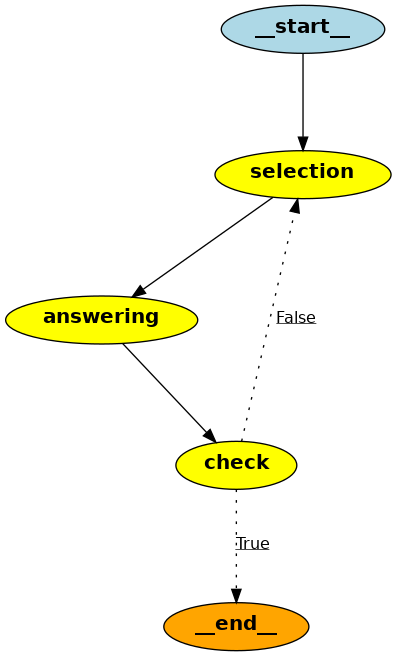

In [18]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())

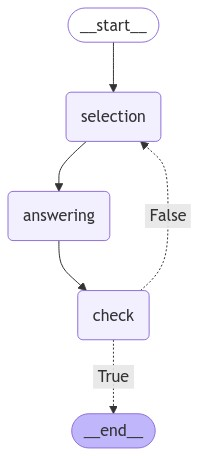

In [19]:
from IPython.display import Image, display

# ちなみに mermaidでの描画も可能です。
display(Image(compiled.get_graph().draw_mermaid_png()))

In [20]:
compiled.get_graph().draw_mermaid()

FileNotFoundError: No such file or directory: '%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	selection(selection)
	answering(answering)
	check(check)
	__end__([<p>__end__</p>]):::last
	__start__ --> selection;
	answering --> check;
	selection --> answering;
	check -. &nbsp;True&nbsp; .-> __end__;
	check -. &nbsp;False&nbsp; .-> selection;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc
'

FileNotFoundError: No such file or directory: '%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	selection(selection)
	answering(answering)
	check(check)
	__end__([<p>__end__</p>]):::last
	__start__ --> selection;
	answering --> check;
	selection --> answering;
	check -. &nbsp;True&nbsp; .-> __end__;
	check -. &nbsp;False&nbsp; .-> selection;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc
'

<IPython.core.display.Image object>

## 9.4 チェックポイント機能：ステートの永続化と再会

In [ ]:
# Google Colab 用なのでコメントアウト
# !pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 langgraph-checkpoint==1.0.11

In [ ]:
# import os
# from google.colab import userdata

# os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_PROJECT"] = "agent-book"

In [19]:
from dotenv import load_dotenv

# 事前に .env ファイルを作って、OPENAI_API_KEY, LANGCHAIN_ENDPOINT などを設定してください
load_dotenv()

True

In [20]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


# グラフのステートを定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])


# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(SystemMessage(content="あなたは最小限の応答をする対話エージェントです。"))
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}


# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}

In [21]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver


def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ:")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ:")
    pprint(checkpoint_tuple.metadata)

In [22]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# チェックポインターを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)

In [23]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-e5323d39-dbc2-4eae-ade5-99cbd967f1f0-0', usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62})]}

In [24]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1ef94e44-103f-614a-8002-bf2f78d74fdb'}}, checkpoint={'v': 1, 'ts': '2024-10-28T04:22:33.600608+00:00', 'id': '1ef94e44-103f-614a-8002-bf2f78d74fdb', 'channel_values': {'query': '私の好きなものはずんだ餅です。覚えておいてね。', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='わかりました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-e5323d39-dbc2-4eae-ade5-99cbd967f1f0-0', usage_metadata={'input_tokens': 48,

In [25]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='わかりました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-e5323d39-dbc2-4eae-ade5-99cbd967f1f0-0', usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62})],
                    'query': '私の好きなものはずんだ餅です。覚えておいてね。'},
 'channel_versions': {'__start__': '000000000000000000000

In [26]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-e5323d39-dbc2-4eae-ade5-99cbd967f1f0-0', usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62}),
  HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='はい、ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 81,

In [27]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1ef94e44-7add-6326-8006-0b06a680d660'}}, checkpoint={'v': 1, 'ts': '2024-10-28T04:22:44.780292+00:00', 'id': '1ef94e44-7add-6326-8006-0b06a680d660', 'channel_values': {'query': '私の好物は何か覚えてる？', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='わかりました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-e5323d39-dbc2-4eae-ade5-99cbd967f1f0-0', usage_metadata={'input_tokens': 48, 'output_to

In [28]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='わかりました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-e5323d39-dbc2-4eae-ade5-99cbd967f1f0-0', usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62}),
                                 HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}),


In [29]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。あなたの好物は何ですか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 36, 'total_tokens': 50, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-aedbf068-3cd1-46e5-9125-97bf71e107d0-0', usage_metadata={'input_tokens': 36, 'output_tokens': 14, 'total_tokens': 50})]}